In [1]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('C:\\Users\\Ria\\product_funnel_analysis\\data\\raw_data.csv')

In [5]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Year,Month,MonthYear
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4,2009,dic,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2009,dic,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2009,dic,2009-12-01
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8,2009,dic,2009-12-01
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0,2009,dic,2009-12-01


In [6]:
df.shape

(400916, 12)

In [7]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'TotalPrice', 'Year', 'Month',
       'MonthYear'],
      dtype='object')

In [8]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalPrice     0
Year           0
Month          0
MonthYear      0
dtype: int64

In [9]:
df = df.dropna(subset=['Customer ID'])

In [10]:
df.shape

(400916, 12)

In [11]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [12]:
df = df.sort_values(['Customer ID', 'InvoiceDate'])

In [13]:
signup = (
    df.groupby('Customer ID')['InvoiceDate']
      .min()
      .reset_index()
      .rename(columns={'InvoiceDate': 'signup_date'})
)

In [14]:
df = df.merge(signup, on='Customer ID', how='left')

In [15]:
df[['Customer ID', 'InvoiceDate', 'signup_date']].head(10)

,Customer ID,InvoiceDate,signup_date
0,12346,2009-12-14 08:34:00,2009-12-14 08:34:00
1,12346,2009-12-14 11:00:00,2009-12-14 08:34:00
2,12346,2009-12-14 11:02:00,2009-12-14 08:34:00
3,12346,2009-12-18 10:47:00,2009-12-14 08:34:00
4,12346,2009-12-18 10:55:00,2009-12-14 08:34:00
5,12346,2010-01-04 09:24:00,2009-12-14 08:34:00
6,12346,2010-01-04 09:53:00,2009-12-14 08:34:00
7,12346,2010-01-14 13:50:00,2009-12-14 08:34:00
8,12346,2010-01-22 13:30:00,2009-12-14 08:34:00
9,12346,2010-03-02 13:08:00,2009-12-14 08:34:00


In [16]:
df['cohort_month'] = df['signup_date'].dt.to_period('M')
df['invoice_month'] = df['InvoiceDate'].dt.to_period('M')

In [17]:
def get_month_diff(row):
    return (row['invoice_month'] - row['cohort_month']).n

df['cohort_index'] = df.apply(get_month_diff, axis=1)

In [18]:
df[['Customer ID', 'cohort_month', 'invoice_month', 'cohort_index']].head(10)

,Customer ID,cohort_month,invoice_month,cohort_index
0,12346,2009-12,2009-12,0
1,12346,2009-12,2009-12,0
2,12346,2009-12,2009-12,0
3,12346,2009-12,2009-12,0
4,12346,2009-12,2009-12,0
5,12346,2009-12,2010-01,1
6,12346,2009-12,2010-01,1
7,12346,2009-12,2010-01,1
8,12346,2009-12,2010-01,1
9,12346,2009-12,2010-03,3


In [19]:
cohort_data = (
    df.groupby(['cohort_month', 'cohort_index'])['Customer ID']
      .nunique()
      .reset_index()
)

In [20]:
cohort_table = cohort_data.pivot(
    index='cohort_month',
    columns='cohort_index',
    values='Customer ID'
)

In [21]:
cohort_table.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2009-12,955.0,337.0,319.0,406.0,363.0,343.0,360.0,327.0,321.0,346.0,403.0,473.0,237.0
2010-01,383.0,79.0,119.0,117.0,101.0,115.0,99.0,88.0,107.0,122.0,116.0,38.0,NaN
2010-02,374.0,89.0,84.0,109.0,92.0,75.0,72.0,107.0,95.0,103.0,27.0,NaN,NaN
2010-03,443.0,84.0,102.0,107.0,103.0,90.0,109.0,134.0,122.0,35.0,NaN,NaN,NaN
2010-04,294.0,57.0,57.0,48.0,54.0,66.0,81.0,77.0,20.0,NaN,NaN,NaN,NaN


In [22]:
cohort_sizes = cohort_table.iloc[:, 0]
retention = cohort_table.divide(cohort_sizes, axis=0)

In [23]:
retention.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,,
2009-12,1.0,0.352880,0.334031,0.425131,0.380105,0.359162,0.376963,0.342408,0.336126,0.362304,0.421990,0.495288,0.248168
2010-01,1.0,0.206266,0.310705,0.305483,0.263708,0.300261,0.258486,0.229765,0.279373,0.318538,0.302872,0.099217,NaN
2010-02,1.0,0.237968,0.224599,0.291444,0.245989,0.200535,0.192513,0.286096,0.254011,0.275401,0.072193,NaN,NaN
2010-03,1.0,0.189616,0.230248,0.241535,0.232506,0.203160,0.246050,0.302483,0.275395,0.079007,NaN,NaN,NaN
2010-04,1.0,0.193878,0.193878,0.163265,0.183673,0.224490,0.275510,0.261905,0.068027,NaN,NaN,NaN,NaN


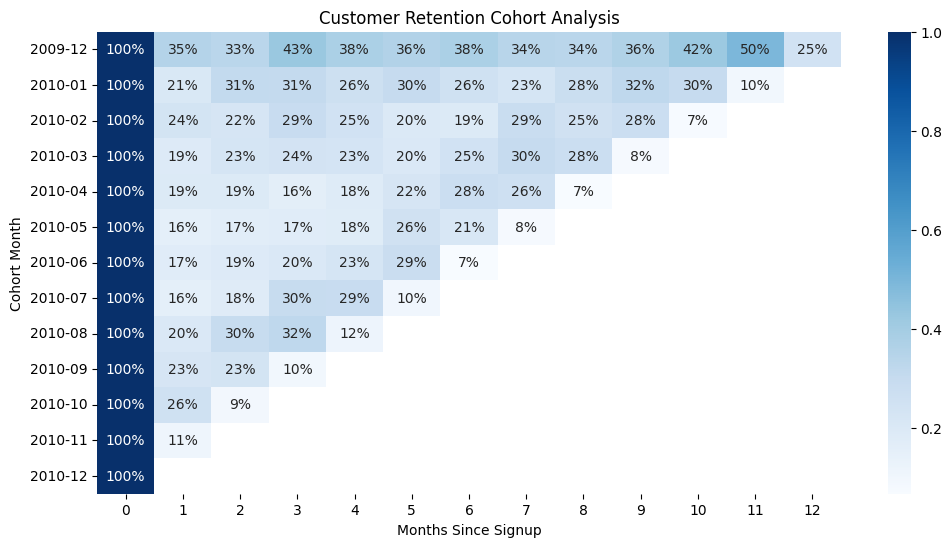

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(
    retention,
    annot=True,
    fmt='.0%',
    cmap='Blues'
)

plt.title('Customer Retention Cohort Analysis')
plt.ylabel('Cohort Month')
plt.xlabel('Months Since Signup')
plt.show()

In [26]:
# Key retention metrics
retention_metrics = retention.copy()

retention_metrics['Month_1_Retention'] = retention_metrics.get(1)
retention_metrics['Month_3_Retention'] = retention_metrics.get(3)
retention_metrics['Month_6_Retention'] = retention_metrics.get(6)

retention_metrics[['Month_1_Retention', 
                   'Month_3_Retention', 
                   'Month_6_Retention']].head()

cohort_index,Month_1_Retention,Month_3_Retention,Month_6_Retention
cohort_month,,,
2009-12,0.352880,0.425131,0.376963
2010-01,0.206266,0.305483,0.258486
2010-02,0.237968,0.291444,0.192513
2010-03,0.189616,0.241535,0.246050
2010-04,0.193878,0.163265,0.275510


In [27]:
avg_retention = retention.mean()

avg_retention

cohort_index
0     1.000000
1     0.205259
2     0.223467
3     0.251924
4     0.235598
5     0.241356
6     0.232684
7     0.250233
8     0.242586
9     0.258812
10    0.265685
11    0.297252
12    0.248168
dtype: float64

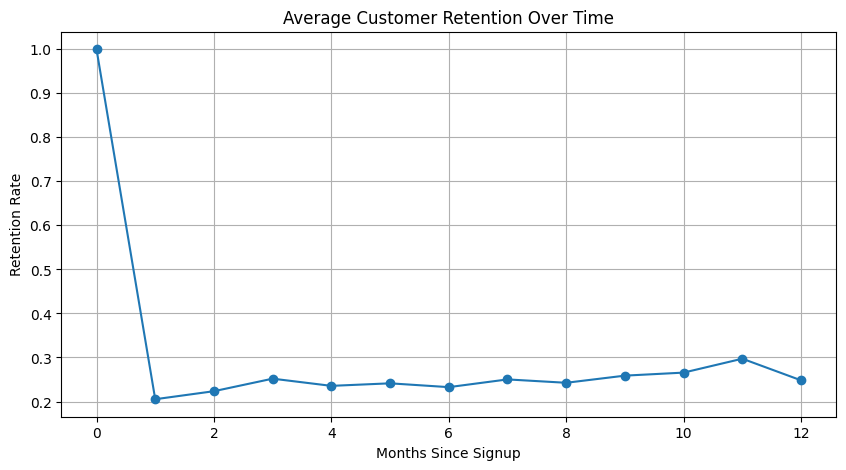

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(avg_retention.index, avg_retention.values, marker='o')
plt.title('Average Customer Retention Over Time')
plt.xlabel('Months Since Signup')
plt.ylabel('Retention Rate')
plt.grid(True)
plt.show()

### Key Insights

- Customer retention drops significantly after the first month, indicating early churn risk.
- Cohorts from late 2009 show relatively stronger long-term retention compared to mid-2010 cohorts.
- Average retention steadily declines over time, suggesting the need for early engagement strategies.

In [30]:
retention_reset = retention.reset_index()
retention_reset['cohort_month'] = retention_reset['cohort_month'].astype(str)

retention_reset.to_csv(
    'data/retention_cohort.csv',
    index=False
)